# Mobile Games

Мы работаетем в компании, которая разрабатывает мобильные игры. Наша главная задача – исследовать несколько аспектов мобильного приложения:
<ol>
    <li>Retention. Необходимо написать функцию для его подсчета. </li>
    <li>В компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных нужно определить, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.</li>
    <li>Предложить метрики для оценки результатов последнего прошедшего тематического события в игре.</li>
</ol>

In [1]:
# импортируем необходимые бибиотеки

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import pingouin as pg
from datetime import datetime

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import norm
import scipy.stats as ss
import statsmodels.api as sm
from tqdm.auto import tqdm

plt.style.use('ggplot')

<h3><b>Задание 1. </b> Retention</h3>

Нам необходимо написать функцию для подсчета Retention, которую можно использовать как на полном датасете, так и на сэмпле данных. Сами данные находятся в двух .csv файлах:
<ul>
    <li>problem1-reg_data.csv – данные о времени регистрации</li>
    <li>problem1-auth_data.csv – данные о времени захода пользователей в игру</li>
</ul>

Для начала считаем эти данные и посмотрим на их структуру.

In [2]:
reg_df = pd.read_csv('problem1-reg_data.csv', sep=';')
auth_df = pd.read_csv('problem1-auth_data.csv', sep=';') 

In [3]:
reg_df.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [4]:
auth_df.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


Можно заметить, что время в датафреймах представлено в неподходящем для нас формате, приведем его к нормальному виду дат.

In [5]:
reg_df['reg_dt'] = pd.to_datetime(reg_df.reg_ts, unit='s').dt.floor('D')
auth_df['auth_dt'] = pd.to_datetime(auth_df.auth_ts, unit='s').dt.floor('D')

Я создала отдельную колонку для даты, чтобы не терять исходные данные со временем. Теперь взглянем, какие типы данных у нас есть, присутстсвуют ли пропущенные значение и есть ли дубликаты в таблицах (если есть, уберем).

In [6]:
print('Таблица регистрации:\n', reg_df.dtypes, '\n')
print('Таблица авторизации:\n', auth_df.dtypes)

Таблица регистрации:
 reg_ts             int64
uid                int64
reg_dt    datetime64[ns]
dtype: object 

Таблица авторизации:
 auth_ts             int64
uid                 int64
auth_dt    datetime64[ns]
dtype: object


In [7]:
reg_df.isna().sum()

reg_ts    0
uid       0
reg_dt    0
dtype: int64

In [8]:
auth_df.isna().sum()

auth_ts    0
uid        0
auth_dt    0
dtype: int64

In [9]:
reg_shape = reg_df.shape[0]
auth_shape = auth_df.shape[0]
print('Размер таблицы регистрации: ', reg_shape)
print('Размер таблицы авторизации: ', auth_shape)

Размер таблицы регистрации:  1000000
Размер таблицы авторизации:  9601013


In [10]:
reg_df.drop_duplicates().shape[0]

1000000

In [11]:
auth_df.drop_duplicates().shape[0]

9601013

Дубликатов в датафреймах нет, отлично!

Перед тем, как реализовывать функцию для подсчета Retention, посмотрим, за какой период в целом у нас данные.

In [12]:
print('Период в reg_df: от', reg_df.reg_dt.min(), ' до ', reg_df.reg_dt.max())
print('Период в auth_df: от', auth_df.auth_dt.min(), ' до ', auth_df.auth_dt.max())

Период в reg_df: от 1998-11-18 00:00:00  до  2020-09-23 00:00:00
Период в auth_df: от 1998-11-18 00:00:00  до  2020-09-23 00:00:00


Данные в таблицах регистрации и авторизации у нас за одинаковый период времени. 

Retention нам необходимо посчитать по дням от даты регистрации игрока. Для того, чтобы python долго не думал, возьмём сэмпл данных за недавний период, а именно:
<ul>
    <li>регистрация игрока с 25 августа 2020 до 10 сентября 2020</li>
    <li>авторизация считается в течение 10 дней после регистрации</li>
 </ul>
 
 Приведу пример: игрок зарегисрировался 26 августа 2020 года, значит, его авторизация будет рассчитана с 26 августа (будет нулевым значением, то есть Retention = 100%) по 5 сентября.

In [13]:
def retention(reg_path, auth_path, start_date, end_date, days):
    
    """
    Функция def retention принимает на вход пять аргументов:

        reg_path – путь к датафрейму с регистрацией игроков
        auth_path – путь к датафрейму с авторизацией игроков
        start_date – дата начала периода регистрации, по которому считаем Retention
        end_date – дата конца периода регистрации, по которому считаем Retention
        days – количество дней после регистрации, по которому считаем Retention
        
    Возвращает heatmap Retention'а для выбранной когорты.
    
    """
    # считываем датафреймы
    reg_data = pd.read_csv(reg_path, sep=';')
    auth_data = pd.read_csv(auth_path, sep=';') 
    
    # приводим дату к удобному формату
    reg_data['reg_dt'] = pd.to_datetime(reg_data.reg_ts, unit='s').dt.floor('D')
    auth_data['auth_dt'] = pd.to_datetime(auth_data.auth_ts, unit='s').dt.floor('D')
    
    # переводим строку в формат даты
    start_date = datetime.strptime(start_date, '%Y-%m-%d').date()
    end_date = datetime.strptime(end_date, '%Y-%m-%d').date()
    
    # определяем временные рамки для датафреймов
    reg_data = reg_data.query('reg_dt>=@start_date and reg_dt<=@end_date')
    auth_data = auth_data.query('auth_dt>=@start_date')
    
    # объединяем две таблицы
    retention_df = reg_data.merge(auth_data, on='uid', how='left')
    
    # создаем колонку с разницей между датой регистрации и авторизации в днях
    retention_df['difference'] = (retention_df.auth_dt - retention_df.reg_dt).dt.days
    
    # отбираем только те кортежи, для которых количество дней с даты регистрации =<10
    # группируем сначала по дате регистрации, затем по дате авторизации
    # агрегируем количество игроков (хотя в таблицах нет дубликатов, я на всякий случай считай nunique)
    retention_df = retention_df.query('difference <= @days') \
        .groupby(['reg_dt', 'auth_dt'], as_index=False) \
        .agg({'uid': 'nunique'})
    
    # здесь я снова считаю колонку с разницей дней и привожу колонку reg_dt к виду год-месяц-дата, так как
    # без этого в heatmap она почему-то отображала помимо даты ещё и время 
    retention_df['period'] = (retention_df.auth_dt - retention_df.reg_dt).dt.days
    retention_df['reg_dt'] = retention_df['reg_dt'].dt.strftime('%Y-%m-%d')
    
    # поворачиваем таблицу
    retention_pivot = retention_df \
        .rename(columns={'reg_dt': 'registration_date'}) \
        .pivot_table(index='registration_date', columns='period', values='uid') 
    
    # делим значения в таблице на первый столбец
    retention_pivot_div = retention_pivot.div(retention_pivot[0], axis=0)
    retention_pivot_div[0] = retention_pivot[0]
    
    plt.figure(figsize=(20, 8))
    plt.title(f'\nRetention по регистрации от {start_date} до {end_date} в течение {days} дней\n', fontsize=20)
    heatmap = sns.heatmap(data=retention_pivot_div, vmin=0.0, vmax=0.1, cmap='crest', annot=True, fmt='.2%')
    
    for t in heatmap.texts:
        current_text = t.get_text()
        if len(current_text) > 5:
            t.set_text(current_text[:4])
        
    # return retention_pivot_div

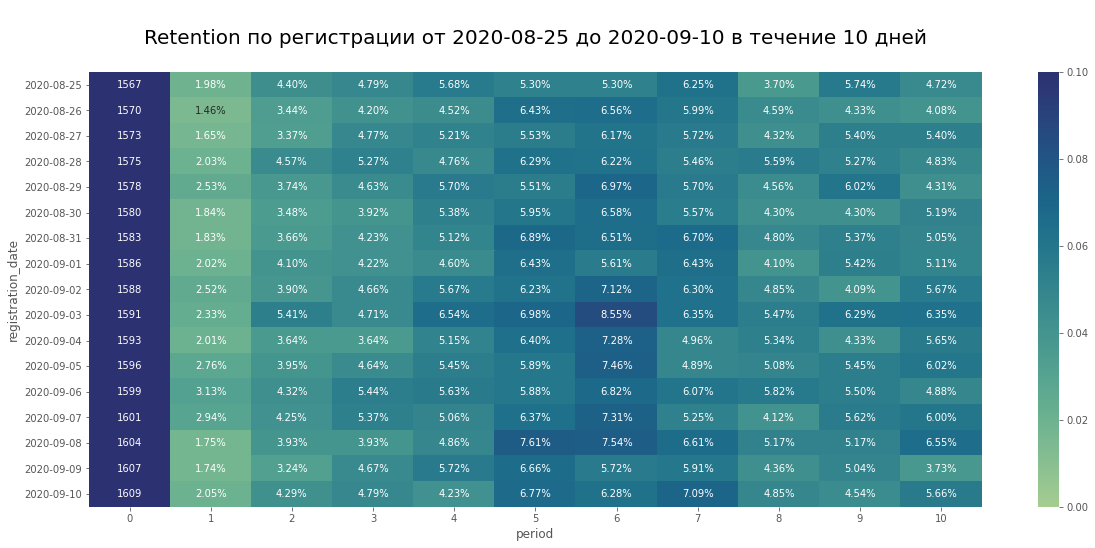

In [14]:
retention('problem1-reg_data.csv', 'problem1-auth_data.csv', '2020-08-25', '2020-09-10', 10)

<h3><b>Задание 2. </b> A/B-тест</h3>

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Нужно выяснить, какой набор предложений можно считать лучшим и какие метрики стоит проанализировать для принятия правильного решения.

Данные лежат в .csv файле, считаем его:

In [15]:
ab_df = pd.read_csv('project_1_task_2.csv', sep=';')

Как и всегда, для начала посмотрим на сам датафрейм, типы данных в нем, есть ли пропущенные значения или дубликаты.

In [16]:
# a - контрольная, b - тестовая
ab_df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [17]:
ab_df.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [18]:
ab_df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [19]:
print('Размер таблицы: ', ab_df.shape[0])

Размер таблицы:  404770


In [20]:
ab_df.drop_duplicates().shape[0]

404770

In [21]:
ab_df.user_id.nunique()

404770

Так как дубликатов среди <b>user_id</b> нет, проверять дубликаты между user_id / revenue, user_id / testgroup не нужно, потому что все значения user_id и так уникальны.

Исходя из задания, нам необходимо посчитать ARPU для тестовой и контрольной групп, также нам известно количество платящих пользователей, значит, мы можем посчитать ARPPU и конверсию в покупку.

Создадим колонку, которая принимает значение 1, если пользователь платящий, и 0, если нет.

In [22]:
ab_df['paying_user'] = ab_df.revenue.apply(lambda x: 1 if x > 0 else 0)

In [23]:
ab_df.head()

,user_id,revenue,testgroup,paying_user
0,1,0,b,0
1,2,0,a,0
2,3,0,a,0
3,4,0,b,0
4,5,0,b,0


Теперь сгруппируем данные по типу группы и применим агрегацию: 
<ul>
    <li>выручку: сумму по revenue</li>
    <li>общее количество пользователей</li>
    <li>количество платящих пользователей</li>
</ul>

In [24]:
result_df = ab_df.groupby('testgroup', as_index=False) \
    .agg({'revenue': 'sum', 
          'user_id': 'count',
          'paying_user': 'sum'})

А теперь считаем метрики.

In [25]:
result_df['ARPU'] = result_df.revenue / result_df.user_id
result_df['ARPPU'] = result_df.revenue / result_df.paying_user
result_df['Convertion_rate'] = result_df.paying_user / result_df.user_id * 100

In [26]:
result_df

,testgroup,revenue,user_id,paying_user,ARPU,ARPPU,Convertion_rate
0,a,5136189,202103,1928,25.413720,2663.998444,0.953969
1,b,5421603,202667,1805,26.751287,3003.658172,0.890624


<br>
Итак, нам необходимо проверить, различаются ли наши метрики статистически значимо. Начнём с <b>ARPU</b>.

In [27]:
# проверяем, что в тестовой группе ARPU на 5% больше (согласно заданию)
100 - result_df.ARPU[0] * 100 / result_df.ARPU[1]

5.000009444962146

Наши гипотезы будут звучать следующим образом:
<ol>
    <li>H0 – ARPU в двух группах не отличаются</li>
    <li>H1 – ARPU в двух группах отличаются стат. значимо</li>
</ol>

Разделим таблицу на контрольную и тестовую группы.

In [28]:
control = ab_df.query('testgroup == "a"')
test = ab_df.query('testgroup == "b"')

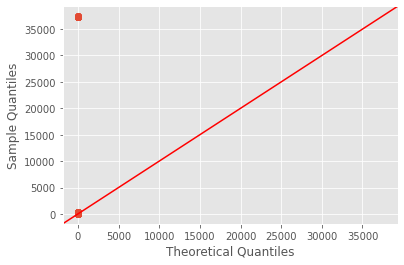

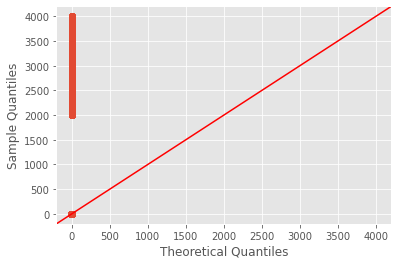

In [29]:
fig = sm.qqplot(control.revenue, line='45')
plt.show()
fig = sm.qqplot(test.revenue, line='45')
plt.show()

Взглянув на QQPlot, можно уже сделать вывод, что распределния двух групп отличаются от нормального, но мы посмотрим ещё и на boxplot.

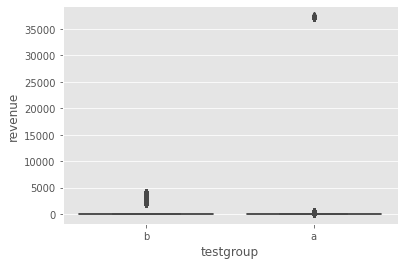

In [30]:
sns.boxplot(data=ab_df, x='testgroup', y='revenue')

Контрольная группа имеет аномально высокие значения прибыли, посмотрим, сколько имеется таких значений и какой процент от всех платящих пользователей в контрольной группе приходится на эти значения.

In [31]:
outlier = ab_df.query('testgroup == "a" & revenue > 35000').shape[0]
outlier

123

In [32]:
outlier / result_df.paying_user[0] * 100

6.379668049792531

In [33]:
outlier_revenue = ab_df.query('testgroup == "a" & revenue > 35000').revenue.sum() / result_df.revenue[0] * 100
outlier_revenue

89.37077665950378

Примерно 6% (123 пользователя) от всех платящих пользователей в контрольной группе имеют чек больше 35000. Это довольно большой процент, учитывая и тот факт, что эти 6% пользователей приносят 89% выручки, поэтому избавиться от этих аномально высоких значений мы не можем. Более того, мы не можем знать точно, не являются ли эти выбросы ошибкой при сборе данных, либо это реальные данные.


Проверим две выборки на нормальность с помощью теста Харке-Бера (method="normaltest"), предназначенный для больших выборок.

In [34]:
pg.normality(data=ab_df, dv="revenue", group="testgroup", method="normaltest")

,W,pval,normal
b,326622.395409,0.0,False
a,585152.731273,0.0,False


Обе выборки не являются представителями нормального распределения.


Проверим наши группы на гомогенность дисперсий с помощью теста Левена.

In [35]:
ss.levene(control.revenue, test.revenue)

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

Тест Левена показал, что дисперсии в двух группах однородны, так как pvalue > 0.05, и H1-гипотезу о том, что дисперсии отличаются, отклоняем.

Для проверки статистической значимости различий ARPU нам необходимо предварительно оценить, какой тест необходимо использовать:
<ol>
    <li>Величины репрезентативны, независимы и случайны. Гарантировать этого нельзя, так как данные были предосталвены на веру, поэтому будем считать, что это так.</li>
    <li>Величины имеют одинаковый масштаб. Это действительно так, количество наблюдений в каждой выборке приблизительно 200 тыс. Хотя стоит заметить, что даже если бы две выборки сильно отличались масштабом, это было бы не критично.</li>
    <li>Наши две выборки по объёму достаточно большие, поэтому ЦПТ соблюдается.</li>
    <li>Диспресии двух групп гомогенны.</li>
</ol>

Так как в контрольной группе присутствует достаточно большое количество выбросов, избавиться от которых мы не можем в силу неизвостной природой их возникновения, для сравнения двух выборок используем Bootstrap средних.

In [36]:
def get_bootstrap(
    bootstrap_control,  # числовые значения первой выборки
    bootstrap_test,     # числовые значения второй выборки
    boot_it=1000,       # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = bootstrap_control.sample(
            len(bootstrap_control), 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = bootstrap_test.sample(
            len(bootstrap_test), 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2))  # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

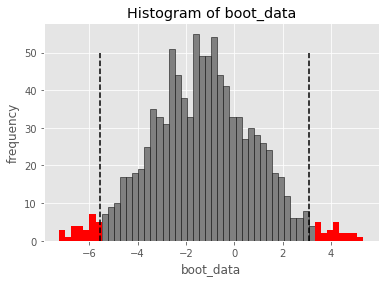

In [37]:
booted_data = get_bootstrap(control.revenue, test.revenue)

In [38]:
booted_data["p_value"]

0.550737398380743

In [39]:
booted_data["quants"]

,0
0.025,-5.563419
0.975,3.092970


Итак, pvalue > 0.05 и в доверительный интервал попал 0 => разницы между группами нет => H1-гипотезу о различиях ARPU между тестовой и контрольной группами <b>отклоняем</b>.

Теперь проверим, различается ли метрика <b>ARPPU</b>.
Гипотезы:
<ol>
    <li>Н0 – ARPPU в группах не различаются</li>
    <li>Н1 – ARPPU в группах отличаются стат. значимо</li>
</ol>

In [40]:
control_pay = ab_df.query('testgroup == "a" & paying_user == 1')
test_pay = ab_df.query('testgroup == "b" & paying_user == 1')

In [41]:
100 - result_df.ARPPU[0] * 100 / result_df.ARPPU[1]

11.308201810607642

Как можно заметить, в тестовой группе ARPPU больше на 11%, чем в контрольной. Также распределение в тестовой группе ближе к равномерному, у контрольной группы имеются выбросы.

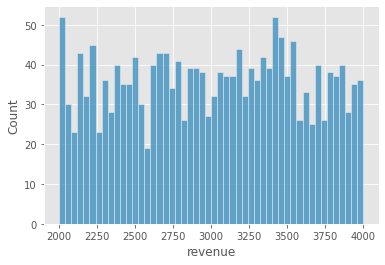

In [42]:
sns.histplot(test_pay.revenue, bins=50)

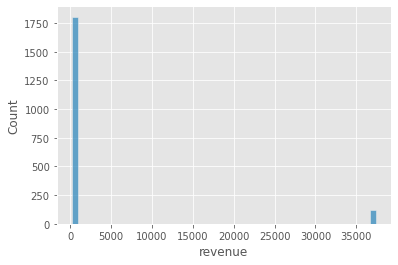

In [43]:
sns.histplot(control_pay.revenue, bins=50)

In [44]:
ss.levene(control_pay.revenue, test_pay.revenue)

LeveneResult(statistic=80.85567421779912, pvalue=3.779689868667878e-19)

Для проверки на нормальность распределений воспользуемся тестом Шапиро-Уилка. В данном случае он используется оправдано, так как количество наблюдений в выборке < 5000.

In [45]:
ss.shapiro(control_pay.revenue)

ShapiroResult(statistic=0.2667924761772156, pvalue=0.0)

In [46]:
ss.shapiro(test_pay.revenue)

ShapiroResult(statistic=0.9583123922348022, pvalue=2.491345674771425e-22)

Тест Левена показал, что гомогенность дисперсий не соблюдается (pvalue < 0.05), тесты Шапиро-Уилка также опровергают нулевую гипотезу о том, что распределения в группах нормальны. Так как дисперсии в выборках не равны (тест Левена показал pvalue < 0.05), для оценки ARPPU снова воспользуемся Bootstrap средних.

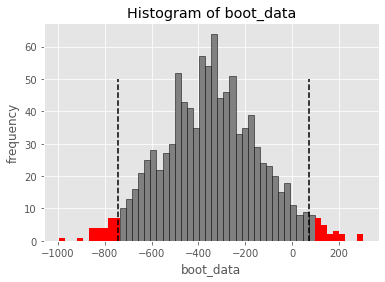

In [47]:
booted_data = get_bootstrap(control_pay.revenue, test_pay.revenue)

In [48]:
booted_data["p_value"]

0.096353848286979

In [49]:
booted_data["quants"]

,0
0.025,-743.944624
0.975,73.675222


P-value снова больше, чем 0.05, и в доверительный интервал попал 0 => ARPPU в тестовой и контрольной группах <b>не отличаются</b>.

Последняя метрика, которую стоит проверить – <b>Conversion Rate</b>. Так как наши данные в данном случае категориальные (paying_user либо 1, либо 0), то для оценки метрики будем применять Хи-квадрат Пирсона.

В контрольной группе CR больше на 7%, чем в тестовой.

Гипотезы:
<ol>
    <li>Н0 – CR в группах не различаются</li>
    <li>Н1 – CR в группах отличаются стат. значимо</li>
</ol>

In [50]:
100 - result_df.Convertion_rate[0] * 100 / result_df.Convertion_rate[1]

-7.112486717401964

In [51]:
# применяем метод
statistic, pvalue = ss.chi2_contingency(pd.crosstab(ab_df.testgroup, ab_df.paying_user))[:2]

In [52]:
statistic, pvalue

(4.374729521260405, 0.03647561892312613)

Несмотря на то, что ARPU и ARPPU не показало стат.значимых отличий, ситуация с CR обратная. P-value < 0.05, а это даёт нам основания <b>отклонить нулевую гипотезу</b> о том, что CR в группах не отличаются.

Исходя из полученных данных, хотелось бы подробнее узнать о выбросах в контрольной группе, откуда они взялись и не является ли это ошибкой при сборе данных.

<h3><b>Задание 3. </b> Metrics</h3>

Метрики для обычной механики:
<ol>
    <li><b>DAU, WAU</b> – дневная и недельная посещаемость игры. Это стандартные метрики для отслеживания активности игроков, нам необходимо знать, в какие дни чаще всего игроки заходят в приложение (будни или выходные), по возможности также знать время суток.</li><br>
    <li><b>Среднее количество пройденных уровней.</b> Эта метрика нужна для того, чтобы понимать, до какого уровня в среднем игрок успеет доходить в течение ивента; возможно, количество уровней необходимо сократить, либо упростить, либо увеличить приз за прохождение уровня, чтобы игроки имели бОльшую мотивацию.</li><br>
    <li><b>Среднее время прохождения каждого из уровней.</b> Метрика немного похожа на предыдущую, также отражает, на каких уровнях игроки "застревают" или теряют к ивенту/игре интерес.</li><br>
    <li><b>Конверсия в прохождение ивента</b> – сколько игроков (новых и старых) вообще проходят эти тематические события? Интересно ли им? Конверсия покажет, насколько успешно ивент завершился.</li><br>
    <li><b>Revenue</b> – если в игре показывается реклама + есть возможность что-то купить за деньги. Нужна для того, чтобы в дальнейшем понять, окупаются ли затраты на разработку.</li><br>
    <li><b>ASD</b> (Average Session Duration) – сколько в среднем времени игрок в целом провёл в игре за одну сессию. Кто-то может заходить в игру несколько раз на пять минут, а кто-то играет час или даже больше. Можно проанализировать, кто из игроков приносит бОльшую выгоду: например те, кто заходит ненадолго несколько раз в день, либо те, кто заходят в игру однократно, но надолго.</li><br>
    <li><b>Stickiness rate</b> – регулярность использования приложения в течение месяца (в нашем случае это ивент). Логично, что чем больше раз игрок посещает приложение, тем лучше.</li><br>
    <li><b>Churn Rate</b> – отток игроков во время ивента. Поможет узнать, сколько игроков отвалилось, исходя из этого оценить, успешен ли был ивент в зависимости от того, какой процент отвалился ранее. Сколько лояльных игроков покинуло приложение? Как их вернуть?</li><br>
    <li><b>Retention</b> по дням. Также для оценки успешности ивента в ходе его проведения. Насколько инетересны уровни и выгодны призы, если пользователь продолжает играть на протяжении, например, двух недель?</li><br>
    <li><b>Количество игроков, прошедших ивент до конца.</b> Если ивент прошёл достаточно высокий процент игроков, которые в целом его проходили, необходимо ли усложнять механику? Или игроки были сильно вовлечены в игру?</li><br>
</ol>

В случае, если мы услжняем механику, к вышеупомянутым метрикам добавятся:
<ol>
    <li><b>Среднее количество игроков, которые не смогли пройти уровень с первого раза (по каждому уровню).</b> Эта метрика покажет, сложный ли уровень в случае, если значительная часть игроков не смогла пройти его с первого раза. Также необходимо учесть, является ли этот уровень одним из последних, или же это начальные уровни. В случае, если уровень начальный, то у игроков может потеряться мотивация проходить ивент дальше, учитвая то, что его откатит назад. Возможно, в следующий раз (если механику решат оставить) требуется провести более тщательное тестирование уровней на сложность.</li><br>
    <li><b>Уровни, которые чаще всего не проходят с первого раза.</b> Исходит из предыдущей (топ среднего количества игроков), в дальнейшем можно отследить, связаны ли эти уровни с теми, после которых игрок отваливается.</li><br>
    <li><b>Уровни, на которых игроки чаще всего бросают прохождение ивента.</b> Как было уже сказано, как вариант необходимо проверить, связано ли это со сложностью определенных уровней, либо же есть какая-то другая причина. Например, игроки бросают ивент в начале, столкнувшись с первым откатом, и теряют мотивацию играть дальше.</li><br>
    <li><b>Уровни, которые игроки чаще всего не проходят несколько раз подряд.</b> Напрямую может влиять на то, что после n-ой попытки пройти уровень, игрок потеряет интерес/взбесится/устанет и перестанет играть. Скорее всего, это неудачный уровень, с другой стороны, к концу ивента уровни должны быть сложными. Также можно посмотреть, оправдана ли награда за прохождение уровня.</li><br>
    <li><b>Среднее количество откатов, после которого игрок перестаёт проходить ивент.</b> Как и в прошлых метриках, тут отображено, на сколько игрока "хватает", чтобы не покинуть игру после череды неудач. Много ли таких игроков? До какого уровня они дошли?</li><br>
</ol>
С точки зрения игрока, механика неудачная, так как откат на несколько (!) уровней назад очень легко может спровоцировать демотивацию. Проще было бы сделать счетчик жизней (если их нет), либо же таймер после нескольких поражений в прохождении уровня, с истечением которого игрок снова может попробовать пройти уровень.